# Import libraries
Download any libraries that you don't have.

In [16]:
from collections import Counter
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from umap.umap_ import UMAP
import plotly.express as px
from sklearn.cluster import KMeans
#from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_score
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multitest import multipletests
from sklearn.preprocessing import StandardScaler

# Setup
Create a configuration dictionary and functions used throughout the script

In [17]:
# Create a configuration dictionary to store parameters
config = {
    'file_path': 'faculty_mesh_terms_matrix.xlsx',
    'pca_components_to_try': range(1, 7),
    'final_pca_components': 5,
    #'dbscan_eps': 0.05,
    #'dbscan_min_samples': 2,
    #'leiden_resolution_pca': 0.2,
    #'leiden_resolution_umap': 0.8,
    'kmeans_n_clusters': 5,
    'silhouette_k_range': range(2, 20),
    'anova_alpha': 0.05,
    'top_n_features_to_plot': 10,
    'cluster_output_path': 'Professors_in_clusters.csv',
    'anova_output_path': 'significant_terms_per_cluster.csv', 
    'top_mesh_terms_output_path': 'Top_Mesh_Terms_Per_Professor.csv',
}

# Create a function to load and preprocess the data
def load_and_preprocess_data(file_path, index_col='Faculty_Full_Name'):
    """Loads and preprocesses the raw data."""
    raw_data = pd.read_excel(file_path, index_col=index_col)
    raw_data.reset_index(inplace=True)
    faculty_names_df = pd.read_excel(file_path, usecols=['Faculty_Full_Name'])
    feature_matrix = raw_data.drop(columns=['Faculty_Full_Name'])
    raw_data.columns = raw_data.columns.str.replace(' ', '_').str.replace('-', '_').str.replace(',', '_')
    feature_matrix.columns = feature_matrix.columns.str.replace(' ', '_').str.replace('-', '_').str.replace(',', '_')
    return raw_data, feature_matrix, faculty_names_df

# Create a function to format the figures
def fig_show(fig):
    fig.update_layout(plot_bgcolor='#255799')
    fig.update_xaxes(title_text="")
    fig.update_yaxes(title_text="")
    fig.update_xaxes(showticklabels=False)
    fig.update_yaxes(showticklabels=False)
    fig.show()

raw_data, feature_matrix, faculty_names_df = load_and_preprocess_data(config['file_path'])

# Calculate the top 5 MeSH terms for each faculty member

In [18]:
mesh_term_columns = [col for col in feature_matrix.columns]
top_mesh_terms_list = []
faculty_names = []

for index, row in raw_data.iterrows():
    professor_name = row['Faculty_Full_Name']
    mesh_term_counts = Counter()
    
    for term in mesh_term_columns:
        count = row[term]
        if isinstance(count, (int, float)) and count > 0:
            mesh_term_counts[term] = count

    top_mesh_terms = [term for term, count in mesh_term_counts.most_common(5)]
    top_mesh_terms_list.append(top_mesh_terms)
    faculty_names.append(professor_name)

top_mesh_terms_df = pd.DataFrame({'Faculty_Full_Name': faculty_names, 'Top_Mesh_Terms': top_mesh_terms_list})
top_mesh_terms_df.set_index('Faculty_Full_Name', inplace=True)
top_mesh_terms_df.to_csv(config['top_mesh_terms_output_path'])

# Principal Component Analysis (PCA)

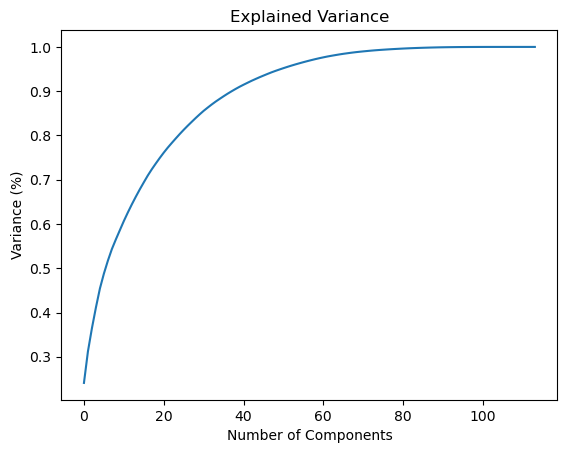

The plot below shows that the faculty members are not well separated with just two components. Therefore, additional components are needed to further separate the faculty members. A couple of outliers appear and who may be driving differences.


In [19]:
# Set up and run PCA on the raw data (columns = MeSH terms, rows = faculty members, values = frquency of terms)
pca = PCA()
pca_embeddings = pca.fit_transform(feature_matrix)

# Visualize explained variance
explained_variance = pca.explained_variance_ratio_
plt.figure()
plt.plot(np.cumsum(explained_variance))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') 
plt.title('Explained Variance')
plt.show()

# Run PCA scatter plot
pca_embeddings_df = pd.DataFrame(pca_embeddings, columns=[f'PC{i+1}' for i in range(pca_embeddings.shape[1])])
pca_embeddings_df['Faculty_Full_Name'] = raw_data['Faculty_Full_Name']
pca_embeddings_df = pca_embeddings_df.merge(top_mesh_terms_df, on='Faculty_Full_Name', how='left')
fig = px.scatter(pca_embeddings_df, x='PC1', y='PC2', hover_name='Faculty_Full_Name',
                 hover_data={'PC1': False, 'PC2': False,
                             'Top_Mesh_Terms': True})
print(f"The plot below shows that the faculty members are not well separated with just two components. Therefore, additional components are needed to further separate the faculty members. A couple of outliers appear and who may be driving differences.")
fig.show()

# Uniform Manifold Approximation and Projection (UMAP)
UMAP is a non-linear dimensionality reduction technique that has more power than PCA. 

In [20]:
# Set up UMAP
umap_embeddings = UMAP().fit_transform(feature_matrix) # UMAP is running on the raw data

# Run 2D UMAP plot
# Here, we can manually subset faculty and then rerun the UMAP. This gives us more power to "zoom in". Later, can make this process more automated.
umap_embeddings_df = pd.DataFrame(umap_embeddings, columns=["V1", "V2"])
umap_embeddings_df['Faculty_Full_Name'] = raw_data['Faculty_Full_Name']
umap_embeddings_df = umap_embeddings_df.merge(top_mesh_terms_df, on='Faculty_Full_Name', how='left')
fig = px.scatter(umap_embeddings_df, x="V1", y="V2", title="UMAP", hover_name="Faculty_Full_Name",
                 hover_data={"V1": False, "V2": False,
                             'Top_Mesh_Terms': True},
                 width=1000, height=1000, color_discrete_sequence=['#fecc07'])
fig_show(fig)

# Elbow plot
An elbow plot gives a rough value for the number of components to run UMAP on. Then, we will plug this number (where the elbow bends) into the num_components parameter in UMAP.

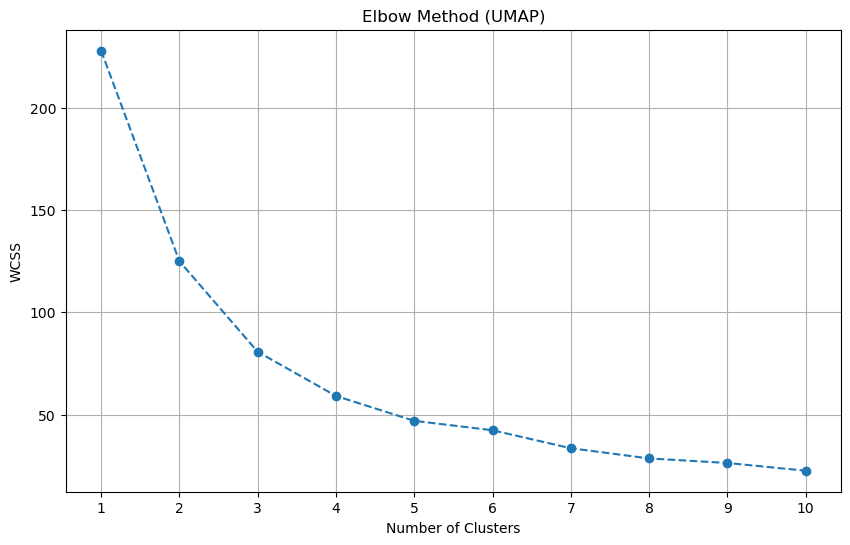

In [21]:
# Run an elbow plot
numeric_data_umap = umap_embeddings_df.select_dtypes(include=['number'])
scaler = StandardScaler()
scaled_data_umap = scaler.fit_transform(numeric_data_umap)
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42, n_init="auto")
    kmeans.fit(scaled_data_umap)
    wcss.append(kmeans.inertia_)
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), wcss, marker='o', linestyle='--')
plt.title('Elbow Method (UMAP)')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.xticks(range(1, 11))
plt.grid(True)
plt.show()

# UMAP iteration with different number of components

In [22]:
# Run UMAPs by iterating through different number of PCA components
pca_result = PCA().fit_transform(feature_matrix)

for num_components in config['pca_components_to_try']:
    pca_reduced_features = pca_result[:, :num_components]
    umap_result = UMAP(random_state=123).fit_transform(pca_reduced_features)
    umap_df_pca = pd.DataFrame(umap_result, columns=["V1", "V2"])
    umap_df_pca['Faculty_Full_Name'] = raw_data['Faculty_Full_Name']
    umap_df_pca = umap_df_pca.merge(top_mesh_terms_df, on='Faculty_Full_Name', how='left')
    fig = px.scatter(umap_df_pca, x="V1", y="V2", title=f"UMAP with {num_components} PCA Components",
                     hover_name="Faculty_Full_Name",
                     hover_data={"V1": False, "V2": False,
                                 'Top_Mesh_Terms': True},
                     width=1000, height=1000, color_discrete_sequence=['#fecc07'])
    fig_show(fig)

/Users/mitalimittal/anaconda3/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning:

n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.



/Users/mitalimittal/anaconda3/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning:

n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.



/Users/mitalimittal/anaconda3/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning:

n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.



/Users/mitalimittal/anaconda3/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning:

n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.



/Users/mitalimittal/anaconda3/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning:

n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.



/Users/mitalimittal/anaconda3/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning:

n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.



# UMAP with PCA components
UMAP takes into account different dimensions and represnts the information in 2D. If you want smaller and more refined clusters, then use more components. But the starting number of components is usually based on the elbow plot.

In [23]:
# Run UMAP with PCA components
#pca_result = PCA().fit_transform(feature_matrix)
num_components = int(input('Enter the number of PCA components to use for UMAP after looking at the iteration and elbow plot: '))
pca_reduced_features = pca_result[:, :num_components]
umap_result = UMAP(random_state=123).fit_transform(pca_reduced_features)
umap_df_pca = pd.DataFrame(umap_result, columns=["V1", "V2"])
umap_df_pca['Faculty_Full_Name'] = raw_data['Faculty_Full_Name']
umap_df_pca = umap_df_pca.merge(top_mesh_terms_df, on='Faculty_Full_Name', how='left')
fig = px.scatter(umap_df_pca, x="V1", y="V2", title="UMAP on PCA Components", hover_name="Faculty_Full_Name",
                 hover_data={"V1": False, "V2": False,
                             'Top_Mesh_Terms': True},
                 width=1000, height=1000, color_discrete_sequence=['#fecc07'])
fig_show(fig)

/Users/mitalimittal/anaconda3/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning:

n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.



# K-means clustering on UMAP coordinates

## Identify optimal number of clusters using silhouette score
Can go with highest peak but then won't include as many clusters. Can have a rule that I want X number of clusters.

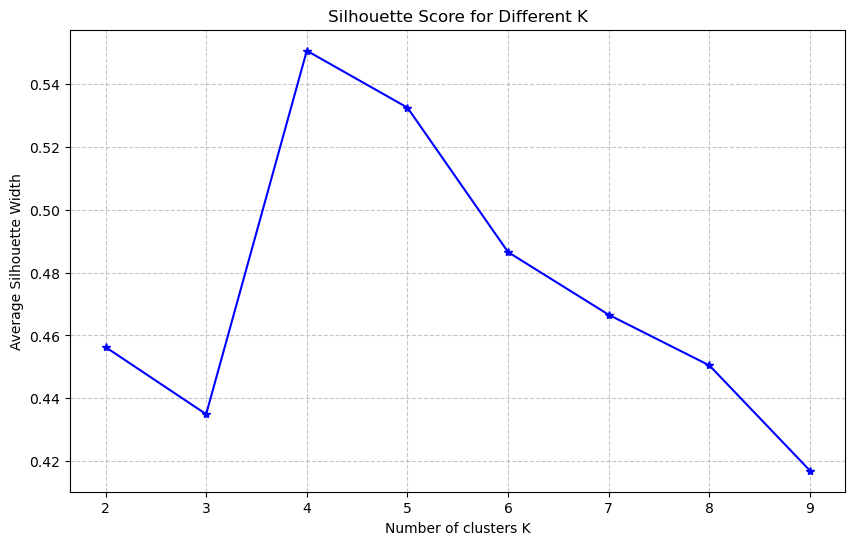

Optimal number of clusters based on silhouette score: 4


In [24]:
def avg_silhouette(data, k):
    kmeans = KMeans(n_clusters=k, random_state=123, n_init="auto").fit(data)
    labels = kmeans.labels_
    sil_score = silhouette_score(data, labels)
    return sil_score

# Create a clean dataframe with only numeric columns for clustering
umap_embeddings_for_silhouette = umap_df_pca[['V1', 'V2']].copy()

# Calculate silhouette scores for different K values
k_values = range(2, 10)
silhouette_scores = [avg_silhouette(umap_embeddings_for_silhouette, k) for k in k_values]

# Calculate silhouette scores for different K
# Min number of clusters is 2. Max number of clusters is 50.
# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(k_values, silhouette_scores, 'b*-')
plt.xlabel('Number of clusters K')
plt.ylabel('Average Silhouette Width')
plt.title('Silhouette Score for Different K')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

# Find the optimal number of clusters
optimal_k = k_values[np.argmax(silhouette_scores)]
print(f"Optimal number of clusters based on silhouette score: {optimal_k}")

In [25]:
# K-means clustering on UMAP coordinates
# Number of clusters for K-means
n_clusters = int(input(f"Enter the number of clusters you want (optimal = {optimal_k}): ")) # You can adjust this parameter to get desired number of clusters

# Perform K-means clustering on UMAP coordinates
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(umap_result)

# Add K-means cluster assignments to the dataframe
umap_df_pca['kmeans_cluster'] = cluster_labels

# Print the number of clusters
print(f"Number of K-means clusters: {n_clusters}")

# Visualize UMAP with K-means clusters
umap_df_pca['Faculty_Full_Name'] = raw_data['Faculty_Full_Name']
umap_df_pca['kmeans_cluster'] = umap_df_pca['kmeans_cluster'].astype(str)
fig = px.scatter(
    umap_df_pca,
    x="V1",
    y="V2",
    color='kmeans_cluster',
    title=f"UMAP with K-means Clusters (k={n_clusters})",
    hover_name="Faculty_Full_Name",
    hover_data={"V1": False, "V2": False, 'Top_Mesh_Terms': True},
    width=1000,
    height=1000,
    color_discrete_sequence=px.colors.qualitative.Bold,
    category_orders={'kmeans_cluster': sorted(umap_df_pca['kmeans_cluster'].astype(float))}
)
fig_show(fig)

# Process clustering results and prepare for analysis
## This block creates a dataframe with numeric data, adds cluster labels, ensures proper data types, and identifies feature columns for further analysis
filtered_data_df = pd.DataFrame(feature_matrix)  # Create a new dataframe with numeric data
filtered_data_df['cluster'] = kmeans.labels_  # Add cluster labels to the dataframe

# Create a clustered dataframe for analysis
cluster_feature_matrix = filtered_data_df

# Ensure the cluster column is properly formatted
cluster_feature_matrix['cluster'] = cluster_feature_matrix['cluster'].astype('category')

Number of K-means clusters: 4


In [26]:
fig.write_html("kmeans_umap_clusters.html")

# Drill down into clusters

In [27]:
# Display all unique mesh terms associated with professor
def get_faculty_mesh_terms(faculty_list, raw_data, mesh_term_columns):
    faculty_mesh_terms = {}
    all_terms = []

    for faculty_name in faculty_list:
        if faculty_name in raw_data['Faculty_Full_Name'].values:
            faculty_row = raw_data[raw_data['Faculty_Full_Name'] == faculty_name].iloc[0]
            unique_terms = [term for term in mesh_term_columns if faculty_row[term] > 0]
            faculty_mesh_terms[faculty_name] = unique_terms
            all_terms.extend(unique_terms)
        else:
            faculty_mesh_terms[faculty_name] = f"Faculty member '{faculty_name}' not found in the data."

    # Find overlapping terms
    term_counts = Counter(all_terms)
    overlapping_terms = {term for term, count in term_counts.items() if count == len(faculty_list) and term in [term for terms in faculty_mesh_terms.values() if isinstance(terms, list) for term in terms]}

    return faculty_mesh_terms, overlapping_terms

# Create a new dataframe with faculty names and their cluster assignments
faculty_clusters_df = pd.DataFrame({
    'Faculty_Full_Name': raw_data['Faculty_Full_Name'],
    'Cluster': kmeans.labels_  # Use the kmeans labels directly
})

faculty_clusters_df.to_csv('Professor_clusters.csv', index=False)

# Returns faculty MeSH terms from a chosen cluster
cluster_input = int((input(f"Enter cluster number: ")))

faculty_in_cluster_list = []

for index, row in faculty_clusters_df.iterrows():
    if row['Cluster'] == cluster_input:
        faculty_in_cluster = row['Faculty_Full_Name']
        faculty_in_cluster_list.append(faculty_in_cluster)

faculty_to_check = faculty_in_cluster_list
faculty_mesh_results, common_terms = get_faculty_mesh_terms(faculty_to_check, raw_data, mesh_term_columns)

# Prepare data for DataFrame
# We'll create a list of dictionaries, where each dictionary will become a row in the DataFrame.
csv_data = []
for faculty_name, terms_or_message in faculty_mesh_results.items():
    if isinstance(terms_or_message, list):
        # Join the list of terms into a single comma-separated string
        terms_string = ", ".join(terms_or_message)
    else:
        # If it's a string (e.g., "Faculty not found"), use it directly
        terms_string = terms_or_message
    
    csv_data.append({
        'Faculty_Full_Name': faculty_name,
        'Associated_MeSH_Terms': terms_string
    })

# Create a pandas DataFrame from the prepared data
df_mesh_results = pd.DataFrame(csv_data)

# Save the DataFrame to a CSV file
# 'index=False' prevents pandas from writing the DataFrame index as a column in the CSV.
output_filename = f"faculty_in_cluster_{cluster_input}.csv"
df_mesh_results.to_csv(output_filename, index=False)

In [28]:
# # Import unique faculty members' MeSH terms as a dictionary
# faculty_unique_mesh_terms_df = pd.read_excel("faculty_unique_mesh_terms.xlsx")

# faculty_unique_mesh_terms_dict = {}
# for index, row in faculty_unique_mesh_terms_df.iterrows():
#     faculty_name = row['Faculty_Full_Name']
#     mesh_terms = row['Unique_Mesh_Terms'].split(', ') if pd.notna(row['Unique_Mesh_Terms']) else []
#     faculty_unique_mesh_terms_dict[faculty_name] = mesh_terms

# selected_faculty_unique_mesh_terms = faculty_unique_mesh_terms_dict[input("Enter faculty name to get unique MeSH terms: ")]

# # Split each string by semicolon and flatten the list
# all_terms = [term.strip() for group in selected_faculty_unique_mesh_terms for term in group.split(';')]

# # Remove 'nan' and empty strings
# cleaned_terms = [term for term in all_terms if term.lower() != 'nan' and term]

# # Print each term on a new line
# for term in cleaned_terms:
#     print(term)